In [1]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression, Lasso
from sklearn.feature_selection import RFE
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
df = pd.read_csv("/Users/reemothman/Downloads/Data-intensive-systems/Datasets_all/A2_dataset_80.csv")

df.shape
df.head()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1675 entries, 0 to 1674
Data columns (total 42 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   AimoScore              1675 non-null   float64
 1   No_1_Angle_Deviation   1675 non-null   float64
 2   No_2_Angle_Deviation   1675 non-null   float64
 3   No_3_Angle_Deviation   1675 non-null   float64
 4   No_4_Angle_Deviation   1675 non-null   float64
 5   No_5_Angle_Deviation   1675 non-null   float64
 6   No_6_Angle_Deviation   1675 non-null   float64
 7   No_7_Angle_Deviation   1675 non-null   float64
 8   No_8_Angle_Deviation   1675 non-null   float64
 9   No_9_Angle_Deviation   1675 non-null   float64
 10  No_10_Angle_Deviation  1675 non-null   float64
 11  No_11_Angle_Deviation  1675 non-null   float64
 12  No_12_Angle_Deviation  1675 non-null   float64
 13  No_13_Angle_Deviation  1675 non-null   float64
 14  No_1_NASM_Deviation    1675 non-null   float64
 15  No_2

In [5]:
target = "AimoScore"

X = df.drop(columns=[target])
y = df[target]


In [12]:
#some features are identical, must be removed
duplicates = X.T.duplicated()
duplicate_cols = X.columns[duplicates]
duplicate_cols
X = X.loc[:, ~duplicates]

In [13]:
# split 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [15]:
# Train the model
model = LinearRegression()
model.fit(X_train, y_train)


,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [17]:
# evaluation 
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"R2: {r2}, RMSE: {rmse}")

#y_pred = model.predict(X_test)
#r2 = r2_score(y_test, y_pred)
#rmse = mean_squared_error(y_test, y_pred, squared=False)
#r2, rmse

R2: 0.4863899887420844, RMSE: 0.16014781430803546


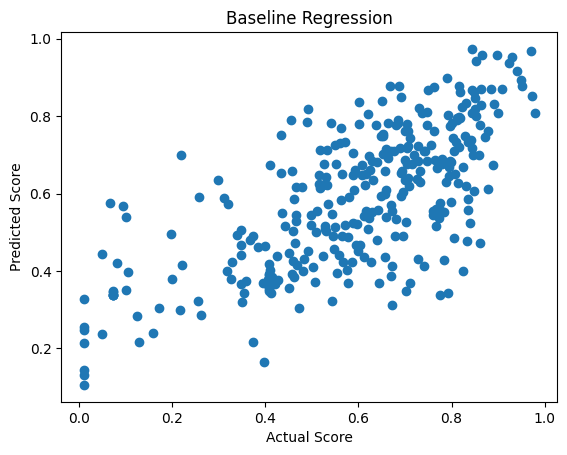

In [18]:
# Plot predicted vs actual

plt.scatter(y_test, y_pred)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Baseline Regression")
plt.show()


In [41]:
# Correlation-Based Feature Selection
# Remove highly correlated features (>0.9).

corr_matrix = X.corr().abs()
upper = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]
X_corr_reduced = X.drop(columns=to_drop)
len(to_drop)

# Split into train/test (again)
#X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
#    X_corr_reduced,
 #   y,
#    test_size=0.2,
 #   random_state=42
#)


Corr-filtered R2: 0.4870508755461206
Corr-filtered RMSE: 0.025614320779348027


In [24]:
# Recursive Feature Elimination (RFE)

rfe = RFE(
    estimator=LinearRegression(),
    n_features_to_select=20
)

rfe.fit(X_train, y_train)

selected_features = X_train.columns[rfe.support_]

print(selected_features)

Index(['No_3_Angle_Deviation', 'No_8_Angle_Deviation', 'No_11_Angle_Deviation',
       'No_12_Angle_Deviation', 'No_13_Angle_Deviation', 'No_6_NASM_Deviation',
       'No_8_NASM_Deviation', 'No_9_NASM_Deviation', 'No_10_NASM_Deviation',
       'No_12_NASM_Deviation', 'No_13_NASM_Deviation', 'No_15_NASM_Deviation',
       'No_17_NASM_Deviation', 'No_19_NASM_Deviation', 'No_21_NASM_Deviation',
       'No_22_NASM_Deviation', 'No_23_NASM_Deviation', 'No_25_NASM_Deviation',
       'No_2_Time_Deviation', 'EstimatedScore'],
      dtype='object')


In [42]:
#Train using selected features

model_rfe = LinearRegression()
model_rfe.fit(X_train[selected_features], y_train)


LinearRegression()


In [26]:
# Lasso Feature Selection, lasso shrinks weak coefficients to zero.
# ! Requires scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [27]:
#train Lasso
lasso = Lasso(alpha=0.01)
lasso.fit(X_scaled, y)

,alpha,0.01
,fit_intercept,True
,precompute,False
,copy_X,True
,max_iter,1000
,tol,0.0001
,warm_start,False
,positive,False
,random_state,None
,selection,'cyclic'


In [30]:
# Selected features

lasso_features = X.columns[lasso.coef_ != 0]
lasso_features

Index(['No_3_Angle_Deviation', 'No_8_Angle_Deviation', 'No_9_Angle_Deviation',
       'No_11_Angle_Deviation', 'No_12_Angle_Deviation',
       'No_13_Angle_Deviation', 'No_6_NASM_Deviation', 'No_9_NASM_Deviation',
       'No_10_NASM_Deviation', 'No_11_NASM_Deviation', 'No_12_NASM_Deviation',
       'No_15_NASM_Deviation', 'No_17_NASM_Deviation', 'No_19_NASM_Deviation',
       'No_2_Time_Deviation', 'EstimatedScore'],
      dtype='object')

In [34]:
# Polynomial / Interaction Features, add interactions.

# Limit degree to 2

poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X)
print(X_poly)

# Warning, Interaction features increase dimensionality significantly — risk of overfitting.

[[0.36107126 0.56193209 0.34672406 ... 0.06779253 0.02844099 0.02934304]
 [0.27977044 0.86800574 0.34672406 ... 0.02247705 0.02631807 0.02674119]
 [0.27977044 0.1037781  0.34672406 ... 0.02247705 0.04644784 0.04719459]
 ...
 [0.77666188 0.3950263  0.34672406 ... 0.02505717 0.01933842 0.01957354]
 [0.95504543 0.79244381 0.34672406 ... 0.03440218 0.14653587 0.09728012]
 [0.30846485 0.09230033 0.34672406 ... 0.02666892 0.09156891 0.07841673]]


In [35]:
# apply symmetry constraints, assignment gives symmetric pairs

sym_pairs = [
    (4,6), (5,7), (8,11), (9,12), (10,13),
    (14,15), (17,18), (21,22), (24,25),
    (26,27), (28,29), (31,32)
]

for a, b in sym_pairs:
    colA = X.columns[a-1]
    colB = X.columns[b-1]
    X[f"{colA}_{colB}_sym"] = (X[colA] + X[colB]) / 2

# Left-right symmetric features were averaged to enforce movement symmetry invariance.


# Experiment Documentation Structur, the notebook should includes:

- 1 Dataset Overview
- 2 Duplicate Feature Removal
- 3 Baseline Regression
- 4 Correlation Filtering
- 5 RFE Selection
- 6 Lasso Selection
- 7 Polynomial Features
- 8 Symmetry Feature Engineering
- 9 Model Comparison Table
- 10 Champion Candidate Discussion


|- Variant       | R² | RMSE | #Features |
|  ------------- | -- | ---- | --------- |
|- Baseline      |    |      |           |
|- Corr filtered |    |      |           |
|- RFE           |    |      |           |
|- Lasso         |    |      |           |
|- Symmetry      |    |      |           |
